In [1]:
#default_exp verbatims/sentiment/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Sentiment - Training

> This module contains all the bits required to train and evaluate verbatim sentiment models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

import optuna

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(SENT_LABELS[1:])
config.attention_probs_dropout_prob: 0.0
config.hidden_dropout_prob: 0.3

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [9]:
df = get_sentiment_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

set_seed(TL_RAND_SEED)
dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer, use_cache=False)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 512]), torch.Size([8, 8]))

## Training

In [11]:
m_pre = f'exp_{m_pre_sentiment}'
m_suf = m_suf_sentiment
base_model_name = base_model_name_sentiment

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = 1, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [13]:
#export
def get_metrics(train_config={}):
    config = {**sentiment_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [16]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [19]:
best_model_cb = SaveModelCallback(monitor='fbeta_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}{base_model_name}{m_suf}_bestmodel')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [20]:
#export
def get_cbs(train_config={}, add_save_model_cb=True):
    config = {**sentiment_train_config, **train_config}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **Learner**

In [21]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [22]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

set_seed(TL_RAND_SEED)
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=SENTIMENT_CLS_PATH)

learn = learn.to_fp16()
learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [23]:
# learn.blurr_summary()

In [24]:
# learn.show_training_loop()

In [25]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [26]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                add_save_model_cb=True, train_config={}):
    config = {**sentiment_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.0015848932787775993, 0.0005754399462603033)

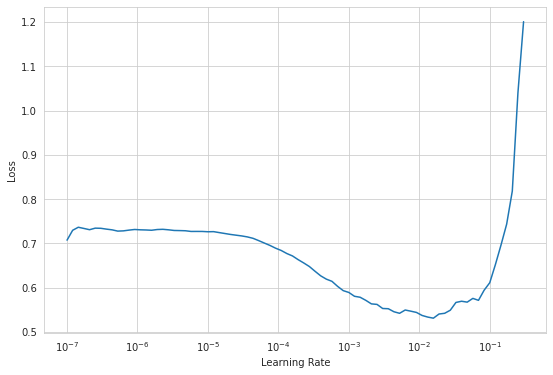

In [27]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [28]:
lr = lr_min; lr_min

0.0015848932787775993

In [29]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(3, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.182619,0.161129,0.932174,0.800629,0.760993,0.854455,0.876516,0.260000,02:29
1,0.146114,0.146698,0.942513,0.819849,0.804443,0.856436,0.882332,0.470000,02:30
2,0.129368,0.131877,0.947525,0.839787,0.815841,0.867327,0.897666,0.410000,02:30


Better model found at epoch 0 with fbeta_score value: 0.8006285537632885.
Better model found at epoch 1 with fbeta_score value: 0.8198489722868267.
Better model found at epoch 2 with fbeta_score value: 0.8397873997624153.


(2.0892961401841602e-06, 6.309573450380412e-07)

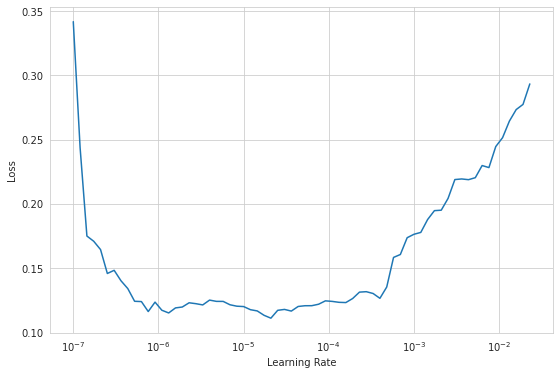

In [30]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [31]:
lr = lr_min; lr_min

2.0892961401841602e-06

In [32]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=slice(lr/10, lr), cbs=fit_cbs)
# learn.fit_one_cycle(5, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.101873,0.131474,0.946585,0.839103,0.806756,0.875743,0.898628,0.380000,05:24
1,0.102771,0.131645,0.946507,0.839196,0.808302,0.875248,0.899029,0.400000,05:23
2,0.125921,0.130602,0.947368,0.840735,0.812609,0.873267,0.899783,0.400000,05:24
3,0.123912,0.130224,0.949170,0.840308,0.831314,0.851485,0.893665,0.480000,05:24
4,0.114420,0.130279,0.947838,0.840547,0.817258,0.867327,0.897903,0.430000,05:23


Better model found at epoch 2 with fbeta_score value: 0.8407351009974536.


In [ ]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

In [ ]:
learn.save(f'{m_pre}{base_model_name}{m_suf}')

Export model for inference

In [ ]:
learn.export(fname=f'{m_pre}{base_model_name}{m_suf}_export.pkl')

Look at results

In [ ]:
# have to add in the opthmize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

In [ ]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [ ]:
inf_learn = load_learner(SENTIMENT_CLS_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')

In [ ]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

In [ ]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

Review final validation loss for best model

In [ ]:
print(SENT_LABELS[1:])

In [ ]:
learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

In [ ]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

## Review

In [ ]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [ ]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config={})

learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

### Lets look at validation metrics

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

In [ ]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

In [ ]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

In [ ]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

In [ ]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

### Overall metrics

In [ ]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [ ]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

In [ ]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [ ]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

In [ ]:
most_freq_class_count / len(eval_targs)

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [ ]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

#### Confusion Matrix

Describes the performance of a classification model

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [ ]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

In [ ]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f1).float(), sample_weight=sample_weight)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(SENT_LABELS[1:][i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.10)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

In [ ]:
classification_report = skm.classification_report(targs, (probs > threshold_f1).float(), 
                                target_names=SENT_LABELS[1:],
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

In [ ]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [ ]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

In [ ]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [ ]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

### Let's look at things by label by label

In [ ]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(SENT_LABELS[1:]):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [ ]:
# label_metrics

In [ ]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results

In [ ]:
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

inf_learn = load_learner(fname=SENTIMENT_CLS_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [ ]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [ ]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

In [ ]:
final_valid_loss = loss.mean().item()

## Build our training loop for hyperparam optimization and final training

In [ ]:
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()
    
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [ ]:
class FastAIPruningCallbackv2(TrackerCallback):
    def __init__(self, trial, monitor='valid_loss', **kwargs) -> None:
        super().__init__(monitor=monitor, **kwargs)
        self._trial = trial

    def after_epoch(self) -> None:
        super().after_epoch()
        
        value = self.recorder.values[-1][self.idx]
        if value is None: return

        self._trial.report(float(value), step=self.epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(self.epoch)
            raise optuna.TrialPruned(message)

In [ ]:
#export
def train(params, trial=None, train_config={}):
    
    config = {**sentiment_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'

    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(SENT_LABELS[1:])
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)

    # 2. build our dls and learner
    df = get_sentiment_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer, train_config=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)

        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)

        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in SENT_LABELS[1:]])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in SENT_LABELS[1:]])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [ ]:
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
#export
def objective(trial, train_config={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 3),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 5),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 3e-4, 3e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 5e-6, 5e-5),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 5e-8, 5e-6),
        'optimize_for': 'fbeta_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, train_config=train_config)
    return score

In [ ]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config = {}
study.optimize(partial(objective, train_config=train_config), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

In [ ]:
m_pre, m_suf = sentiment_train_config['m_pre'], sentiment_train_config['m_suf']
full_model_name = f"{m_pre}{sentiment_train_config['base_model_name']}{m_suf}"
   
pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['fbeta_score'] = study.best_value

with open(f"{sentiment_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{sentiment_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", 
                 index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

### Training with best params

In [ ]:
with open(f"{sentiment_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
scores, train_res_df = train(params=best_params, train_config={})

In [ ]:
scores

In [ ]:
train_res_df.head()

In [ ]:
# load scores
with open(SENTIMENT_CLS_PATH/f'{yyyymmdd}_{full_model_name}_train_scores.json') as f: 
    training_results = json.load(f)
    
training_results

In [ ]:
inf_learn = load_learner(SENTIMENT_CLS_PATH/f'{yyyymmdd}_{full_model_name}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

## Inference

### Inference (ad-hoc documents)

In [ ]:
print(SENT_LABELS[1:])

In [ ]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

### Inference (batch)

In [ ]:
#export
def get_sentiment_preds(inf_df, learner_export_path=None, train_scores_path=None, yyyymmdd=None,
                        device=torch.device('cpu'), train_config={}):
    
    config = {**sentiment_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    if (yyyymmdd is None): yyyymmdd = datetime.today().strftime("%Y%m%d")
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    prob_labels = ['prob_' + lbl for lbl in  SENT_LABELS[1:]]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in  SENT_LABELS[1:]:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, all_probs, SENT_LABELS[1:]

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_sentiment_preds(inf_df, device=device)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

In [ ]:
preds_df.head()

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in SENT_LABELS[1:]]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [ ]:
for lbl in SENT_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > scores['opt_th']).astype(np.int64)

In [ ]:
final_df.head()

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

## Playground

In [ ]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in SENT_LABELS[1:] ]
prob_lbls = [ f'prob_{lbl}' for lbl in SENT_LABELS[1:] ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])